# Imports

In [1]:
import pandas as pd
#import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.convnext import ConvNeXtXLarge
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

# Data loading & overview

In [2]:
df = pd.read_csv('Data/cleaned_data.csv')

In [3]:
df

,description,image,lvl_1_category,lvl_2_category,lvl_3_category,lvl_1_category_encoded
0,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,Curtains & Accessories,Curtains,4
1,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,Baby Bath & Skin,Baby Bath Towels,0
2,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,Baby Bath & Skin,Baby Bath Towels,0
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,Bed Linen,Bedsheets,4
4,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,Bed Linen,Bedsheets,4
...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker...,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,Baby & Kids Gifts,Stickers,0
1046,Wallmantra Large Vinyl Sticker Sticker (Pack o...,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,Baby & Kids Gifts,Stickers,0
1047,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,Baby & Kids Gifts,Stickers,0
1048,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,Baby & Kids Gifts,Stickers,0


# Train, val, test

In [4]:
X = df.loc[:, ['image']]
y = df.loc[:, ['lvl_1_category_encoded']]

# calculate the number of images necessary for the test dataset to be at the chosen proportion of the train dataset ;
# this will be used later to calculate the proportion of the validation dataset
test_size = round(len(df) *0.2)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=42)

train_val_dataset = pd.concat([X_train_val, y_train_val], axis=1)
test_dataset = pd.concat([X_test, y_test], axis=1)

# setting validation set size so that it is the same as the test set size (in number of images)
val_size = test_size / len(train_val_dataset)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, stratify=y_train_val, test_size=val_size, random_state=42
)

train_dataset = pd.concat([X_train, y_train], axis=1)
val_dataset = pd.concat([X_val, y_val], axis=1)

In [5]:
# Sort images by dataset type (train, validation, test) and category, in folders
n_labels = 7

""""
#os.makedirs('Data/Images/Sorted_images')
original_folder_path = 'Data/Images/Unsorted_images/'

for dataset in [train_dataset, val_dataset, test_dataset]:
    dataset_name = [x for x in globals() if globals()[x] is dataset][0]
    #os.makedirs(f'Data/Images/Sorted_images/{dataset_name}')
    for i in range(n_labels):
        #os.makedirs(f'Data/Images/Sorted_images/{dataset_name}/category_{i}')
        destination_folder_path = f'Data/Images/Sorted_images/{dataset_name}/category_{i}/'
        images_cat_i = dataset.loc[dataset['lvl_1_category_encoded']==i, 'image']
        originals_paths = [original_folder_path + img for img in images_cat_i]
        destination_paths = [destination_folder_path + img for img in images_cat_i]
        for y in range(len(originals_paths)):
            shutil.copy(originals_paths[y], destination_paths[y])
"""

'"\n#os.makedirs(\'Data/Images/Sorted_images\')\noriginal_folder_path = \'Data/Images/Unsorted_images/\'\n\nfor dataset in [train_dataset, val_dataset, test_dataset]:\n    dataset_name = [x for x in globals() if globals()[x] is dataset][0]\n    #os.makedirs(f\'Data/Images/Sorted_images/{dataset_name}\')\n    for i in range(n_labels):\n        #os.makedirs(f\'Data/Images/Sorted_images/{dataset_name}/category_{i}\')\n        destination_folder_path = f\'Data/Images/Sorted_images/{dataset_name}/category_{i}/\'\n        images_cat_i = dataset.loc[dataset[\'lvl_1_category_encoded\']==i, \'image\']\n        originals_paths = [original_folder_path + img for img in images_cat_i]\n        destination_paths = [destination_folder_path + img for img in images_cat_i]\n        for y in range(len(originals_paths)):\n            shutil.copy(originals_paths[y], destination_paths[y])\n'

In [6]:
def dataset_fct(path) :
    dataset = tf.keras.utils.image_dataset_from_directory(
        path, labels='inferred', label_mode='categorical', class_names=None, 
        batch_size = 32, image_size=(224, 224), shuffle=True, seed=42, validation_split=None, subset=None
    )
    return dataset

In [7]:
train_set_path = "Data/Images/Sorted_images/train_dataset/"
val_set_path = "Data/Images/Sorted_images/val_dataset/"
test_set_path = "Data/Images/Sorted_images/test_dataset/"

train_set = dataset_fct(train_set_path)
val_set = dataset_fct(val_set_path)
test_set = dataset_fct(test_set_path)

Found 630 files belonging to 7 classes.
Found 210 files belonging to 7 classes.
Found 210 files belonging to 7 classes.


# Defining functions

In [8]:
def create_model(base_model) :
    # Récupération modèle pré-entraîné
    model0 = base_model(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_labels, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [9]:
def create_model_with_data_augmentation(base_model) :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    base = base_model(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(n_labels, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [10]:
def fit_model_and_get_history(model):
    history = model.fit(
        train_set,
        validation_data=val_set,
        batch_size=32, 
        epochs=50, 
        callbacks=callbacks_list, 
        verbose=1
    )
    return history

In [11]:
def get_last_epoch_scores(model):
    loss, accuracy = model.evaluate(train_set, verbose=True)
    print("Training Accuracy   : {:.4f}".format(accuracy))
    print()
    loss, accuracy = model.evaluate(val_set, verbose=True)
    print("Validation Accuracy :  {:.4f}".format(accuracy))

In [12]:
def get_optimal_epoch_scores(model, model_backup_path):
    model.load_weights(model_backup_path)

    loss, accuracy = model.evaluate(val_set, verbose=False)
    print("Validation Accuracy :  {:.4f}".format(accuracy))

    loss, accuracy = model.evaluate(test_set, verbose=False)
    print("Test Accuracy       :  {:.4f}".format(accuracy))

# VGG16

## without data augmentation

In [13]:
# Create model
VGG16_1 = create_model(base_model=VGG16)

# Create callback
VGG16_1_save_path = "VGG16_1_best_weights.h5"
checkpoint = ModelCheckpoint(VGG16_1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
VGG16_1_history = fit_model_and_get_history(VGG16_1)

Epoch 1/50


2023-08-13 23:05:29.480482: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


20/20 [==============================] - ETA: 0s - loss: 6.8629 - accuracy: 0.4635
Epoch 1: val_loss improved from inf to 1.80867, saving model to VGG16_1_best_weights.h5
20/20 [==============================] - 50s 2s/step - loss: 6.8629 - accuracy: 0.4635 - val_loss: 1.8087 - val_accuracy: 0.7571
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 2.4201 - accuracy: 0.6841
Epoch 2: val_loss improved from 1.80867 to 1.41941, saving model to VGG16_1_best_weights.h5
20/20 [==============================] - 51s 3s/step - loss: 2.4201 - accuracy: 0.6841 - val_loss: 1.4194 - val_accuracy: 0.7905
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.5887 - accuracy: 0.7540
Epoch 3: val_loss improved from 1.41941 to 1.38072, saving model to VGG16_1_best_weights.h5
20/20 [==============================] - 50s 2s/step - loss: 1.5887 - accuracy: 0.7540 - val_loss: 1.3807 - val_accuracy: 0.7810
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.

In [15]:
get_last_epoch_scores(model=VGG16_1)

20/20 [==============================] - 38s 2s/step - loss: 0.0037 - accuracy: 1.0000
Training Accuracy   : 1.0000

7/7 [==============================] - 13s 2s/step - loss: 1.2409 - accuracy: 0.8333
Validation Accuracy :  0.8333


In [16]:
get_optimal_epoch_scores(model=VGG16_1, model_backup_path=VGG16_1_save_path)

Validation Accuracy :  0.8190
Test Accuracy       :  0.7524


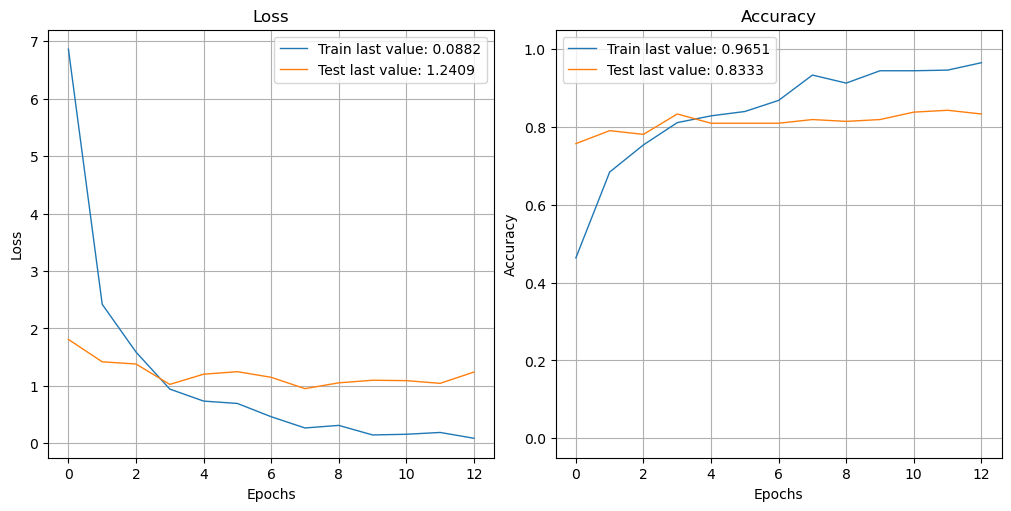

In [17]:
show_history(VGG16_1_history)
plot_history(VGG16_1_history, path="standard.png")
plt.close()

## with data augmentation

In [22]:
# Create model
VGG16_2 = create_model_with_data_augmentation(base_model=VGG16)

# Create callback
VGG16_2_save_path = "VGG16_2_best_weights.h5"
checkpoint = ModelCheckpoint(VGG16_2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [24]:
VGG16_2_history = VGG16_2.fit(
    train_set,
    validation_data=val_set,
    batch_size=32, 
    epochs=50, 
    callbacks=callbacks_list, 
    verbose=1
)

VGG16_2_history

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.9796 - accuracy: 0.2143
Epoch 1: val_loss improved from inf to 1.45947, saving model to VGG16_2_best_weights.h5
20/20 [==============================] - 50s 2s/step - loss: 1.9796 - accuracy: 0.2143 - val_loss: 1.4595 - val_accuracy: 0.6143
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.4527 - accuracy: 0.5302
Epoch 2: val_loss improved from 1.45947 to 1.06772, saving model to VGG16_2_best_weights.h5
20/20 [==============================] - 49s 2s/step - loss: 1.4527 - accuracy: 0.5302 - val_loss: 1.0677 - val_accuracy: 0.7476
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.1456 - accuracy: 0.6429
Epoch 3: val_loss improved from 1.06772 to 0.90353, saving model to VGG16_2_best_weights.h5
20/20 [==============================] - 49s 2s/step - loss: 1.1456 - accuracy: 0.6429 - val_loss: 0.9035 - val_accuracy: 0.7667
Epoch 4/50
20/20 [==============================] - ETA: 0s

Epoch 29/50
20/20 [==============================] - ETA: 0s - loss: 0.4324 - accuracy: 0.8587
Epoch 29: val_loss did not improve from 0.58515
20/20 [==============================] - 49s 2s/step - loss: 0.4324 - accuracy: 0.8587 - val_loss: 0.5868 - val_accuracy: 0.8333
Epoch 30/50
20/20 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.8651
Epoch 30: val_loss did not improve from 0.58515
20/20 [==============================] - 49s 2s/step - loss: 0.4089 - accuracy: 0.8651 - val_loss: 0.6081 - val_accuracy: 0.8143
Epoch 31/50
20/20 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.8905
Epoch 31: val_loss improved from 0.58515 to 0.58293, saving model to VGG16_2_best_weights.h5
20/20 [==============================] - 49s 2s/step - loss: 0.3796 - accuracy: 0.8905 - val_loss: 0.5829 - val_accuracy: 0.8333
Epoch 32/50
20/20 [==============================] - ETA: 0s - loss: 0.3589 - accuracy: 0.8984
Epoch 32: val_loss did not improve from 0.58

In [25]:
get_last_epoch_scores(model=VGG16_2)

20/20 [==============================] - 37s 2s/step - loss: 0.2045 - accuracy: 0.9413
Training Accuracy   : 0.9413

7/7 [==============================] - 13s 2s/step - loss: 0.5922 - accuracy: 0.8286
Validation Accuracy :  0.8286


In [26]:
get_optimal_epoch_scores(model=VGG16_2, model_backup_path=VGG16_2_save_path)

Validation Accuracy :  0.8190
Test Accuracy       :  0.7571


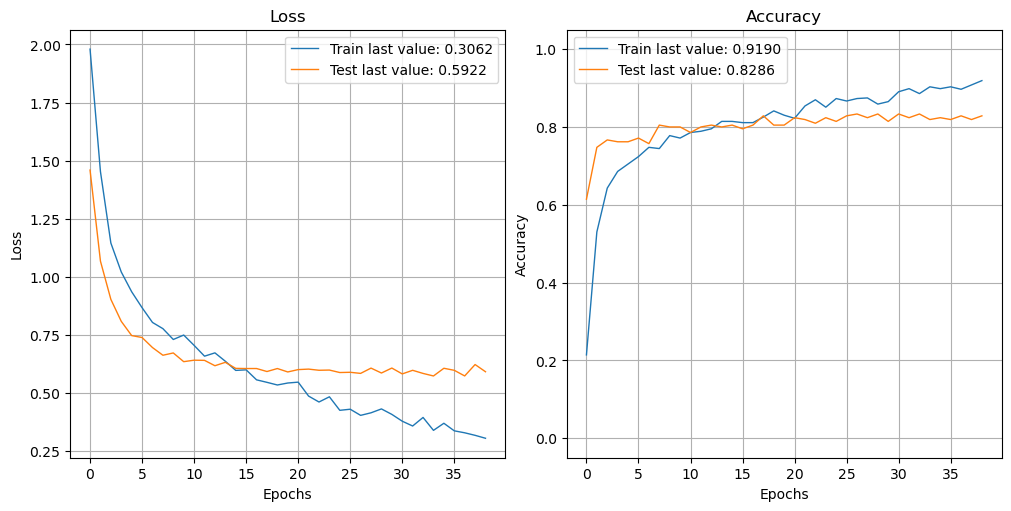

In [27]:
show_history(VGG16_2_history)
plot_history(VGG16_2_history, path="standard.png")
plt.close()

# EfficientNetV2M

## without data augmentation

In [28]:
# Create model
EfficientNetV2M_1 = create_model(base_model=EfficientNetV2M)

# Create callback
EfficientNetV2M_1_save_path = "EfficientNetV2M_1_best_weights.h5"
checkpoint = ModelCheckpoint(
    EfficientNetV2M_1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

                                                                 ']                               
                                                                                                  
 block2b_project_bn (BatchNorma  (None, 56, 56, 48)  192         ['block2b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_drop (Dropout)         (None, 56, 56, 48)   0           ['block2b_project_bn[0][0]']     
                                                                                                  
 block2b_add (Add)              (None, 56, 56, 48)   0           ['block2b_drop[0][0]',           
                                                                  'block2a_project_bn[0][0]']     
                                                                                                  
 block2c_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 320)  1280       ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 320)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 28, 28, 80)   25600       ['block3b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 80)  320         ['block3b_project_conv[0][0]']   
 lization)

 2D)                                                             ']                               
                                                                                                  
 block4a_bn (BatchNormalization  (None, 14, 14, 320)  1280       ['block4a_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4a_activation (Activation  (None, 14, 14, 320)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 320)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
          

                                                                                                  
 block4c_se_reshape (Reshape)   (None, 1, 1, 640)    0           ['block4c_se_squeeze[0][0]']     
                                                                                                  
 block4c_se_reduce (Conv2D)     (None, 1, 1, 40)     25640       ['block4c_se_reshape[0][0]']     
                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 640)    26240       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 14, 14, 640)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_p

 block4e_se_expand (Conv2D)     (None, 1, 1, 640)    26240       ['block4e_se_reduce[0][0]']      
                                                                                                  
 block4e_se_excite (Multiply)   (None, 14, 14, 640)  0           ['block4e_activation[0][0]',     
                                                                  'block4e_se_expand[0][0]']      
                                                                                                  
 block4e_project_conv (Conv2D)  (None, 14, 14, 160)  102400      ['block4e_se_excite[0][0]']      
                                                                                                  
 block4e_project_bn (BatchNorma  (None, 14, 14, 160)  640        ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_d

 block4g_project_conv (Conv2D)  (None, 14, 14, 160)  102400      ['block4g_se_excite[0][0]']      
                                                                                                  
 block4g_project_bn (BatchNorma  (None, 14, 14, 160)  640        ['block4g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4g_drop (Dropout)         (None, 14, 14, 160)  0           ['block4g_project_bn[0][0]']     
                                                                                                  
 block4g_add (Add)              (None, 14, 14, 160)  0           ['block4g_drop[0][0]',           
                                                                  'block4f_add[0][0]']            
                                                                                                  
 block5a_e

                                                                                                  
 block5c_expand_conv (Conv2D)   (None, 14, 14, 1056  185856      ['block5b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 14, 14, 1056  4224       ['block5c_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5c_expand_activation (Act  (None, 14, 14, 1056  0          ['block5c_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5c_d

                                                                                                  
 block5e_expand_bn (BatchNormal  (None, 14, 14, 1056  4224       ['block5e_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5e_expand_activation (Act  (None, 14, 14, 1056  0          ['block5e_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5e_dwconv2 (DepthwiseConv  (None, 14, 14, 1056  9504       ['block5e_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5e_b

                                                                                                  
 block5g_expand_activation (Act  (None, 14, 14, 1056  0          ['block5g_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5g_dwconv2 (DepthwiseConv  (None, 14, 14, 1056  9504       ['block5g_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5g_bn (BatchNormalization  (None, 14, 14, 1056  4224       ['block5g_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5g_a

                                                                                                  
 block5i_dwconv2 (DepthwiseConv  (None, 14, 14, 1056  9504       ['block5i_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5i_bn (BatchNormalization  (None, 14, 14, 1056  4224       ['block5i_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5i_activation (Activation  (None, 14, 14, 1056  0          ['block5i_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5i_s

                                                                                                  
 block5k_bn (BatchNormalization  (None, 14, 14, 1056  4224       ['block5k_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5k_activation (Activation  (None, 14, 14, 1056  0          ['block5k_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5k_se_squeeze (GlobalAver  (None, 1056)        0           ['block5k_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5k_s

                                                                                                  
 block5m_activation (Activation  (None, 14, 14, 1056  0          ['block5m_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5m_se_squeeze (GlobalAver  (None, 1056)        0           ['block5m_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5m_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block5m_se_squeeze[0][0]']     
                                                                                                  
 block5m_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block5m_se_reshape[0][0]']     
          

                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 1056)        0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 1056)   47520       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_s

 block6c_se_excite (Multiply)   (None, 7, 7, 1824)   0           ['block6c_activation[0][0]',     
                                                                  'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, 7, 7, 304)    554496      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 7, 7, 304)   1216        ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 7, 7, 304)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_a

 block6e_project_bn (BatchNorma  (None, 7, 7, 304)   1216        ['block6e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6e_drop (Dropout)         (None, 7, 7, 304)    0           ['block6e_project_bn[0][0]']     
                                                                                                  
 block6e_add (Add)              (None, 7, 7, 304)    0           ['block6e_drop[0][0]',           
                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 7, 7, 1824)   554496      ['block6e_add[0][0]']            
                                                                                                  
 block6f_e

 block6g_add (Add)              (None, 7, 7, 304)    0           ['block6g_drop[0][0]',           
                                                                  'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 7, 7, 1824)   554496      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 7, 7, 1824)  7296        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 7, 7, 1824)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block6j_expand_bn (BatchNormal  (None, 7, 7, 1824)  7296        ['block6j_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6j_expand_activation (Act  (None, 7, 7, 1824)  0           ['block6j_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6j_dwconv2 (DepthwiseConv  (None, 7, 7, 1824)  16416       ['block6j_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6j_bn (BatchNormalization  (None, 7, 7, 1824)  7296        ['block6j_dwconv2[0][0]']        
 )        

                                                                                                  
 block6l_dwconv2 (DepthwiseConv  (None, 7, 7, 1824)  16416       ['block6l_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6l_bn (BatchNormalization  (None, 7, 7, 1824)  7296        ['block6l_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6l_activation (Activation  (None, 7, 7, 1824)  0           ['block6l_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6l_s

 )                                                                                                
                                                                                                  
 block6n_activation (Activation  (None, 7, 7, 1824)  0           ['block6n_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6n_se_squeeze (GlobalAver  (None, 1824)        0           ['block6n_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6n_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6n_se_squeeze[0][0]']     
                                                                                                  
 block6n_s

 block6p_se_squeeze (GlobalAver  (None, 1824)        0           ['block6p_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6p_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6p_se_squeeze[0][0]']     
                                                                                                  
 block6p_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6p_se_reshape[0][0]']     
                                                                                                  
 block6p_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6p_se_reduce[0][0]']      
                                                                                                  
 block6p_se_excite (Multiply)   (None, 7, 7, 1824)   0           ['block6p_activation[0][0]',     
          

 block6r_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6r_se_reshape[0][0]']     
                                                                                                  
 block6r_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6r_se_reduce[0][0]']      
                                                                                                  
 block6r_se_excite (Multiply)   (None, 7, 7, 1824)   0           ['block6r_activation[0][0]',     
                                                                  'block6r_se_expand[0][0]']      
                                                                                                  
 block6r_project_conv (Conv2D)  (None, 7, 7, 304)    554496      ['block6r_se_excite[0][0]']      
                                                                                                  
 block6r_project_bn (BatchNorma  (None, 7, 7, 304)   1216        ['block6r_project_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 block7b_drop (Dropout)         (None, 7, 7, 512)    0           ['block7b_project_bn[0][0]']     
                                                                                                  
 block7b_add (Add)              (None, 7, 7, 512)    0           ['block7b_drop[0][0]',           
                                                                  'block7a_project_bn[0][0]']     
                                                                                                  
 block7c_expand_conv (Conv2D)   (None, 7, 7, 3072)   1572864     ['block7b_add[0][0]']            
                                                                                                  
 block7c_expand_bn (BatchNormal  (None, 7, 7, 3072)  12288       ['block7c_expand_conv[0][0]']    
 ization) 

                                                                  'block7c_add[0][0]']            
                                                                                                  
 block7e_expand_conv (Conv2D)   (None, 7, 7, 3072)   1572864     ['block7d_add[0][0]']            
                                                                                                  
 block7e_expand_bn (BatchNormal  (None, 7, 7, 3072)  12288       ['block7e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7e_expand_activation (Act  (None, 7, 7, 3072)  0           ['block7e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7e_d

In [29]:
EfficientNetV2M_1_history = fit_model_and_get_history(EfficientNetV2M_1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 0.8996 - accuracy: 0.7476
Epoch 1: val_loss improved from inf to 0.52546, saving model to EfficientNetV2M_1_best_weights.h5
20/20 [==============================] - 45s 2s/step - loss: 0.8996 - accuracy: 0.7476 - val_loss: 0.5255 - val_accuracy: 0.8667
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.9032
Epoch 2: val_loss improved from 0.52546 to 0.46087, saving model to EfficientNetV2M_1_best_weights.h5
20/20 [==============================] - 34s 2s/step - loss: 0.4027 - accuracy: 0.9032 - val_loss: 0.4609 - val_accuracy: 0.8619
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.9349
Epoch 3: val_loss improved from 0.46087 to 0.42230, saving model to EfficientNetV2M_1_best_weights.h5
20/20 [==============================] - 35s 2s/step - loss: 0.2635 - accuracy: 0.9349 - val_loss: 0.4223 - val_accuracy: 0.8619
Epoch 4/50
20/20 [===========

In [30]:
get_last_epoch_scores(model=EfficientNetV2M_1)

20/20 [==============================] - 25s 1s/step - loss: 0.0157 - accuracy: 0.9937
Training Accuracy   : 0.9937

7/7 [==============================] - 9s 1s/step - loss: 0.4326 - accuracy: 0.8857
Validation Accuracy :  0.8857


In [31]:
get_optimal_epoch_scores(model=EfficientNetV2M_1, model_backup_path=EfficientNetV2M_1_save_path)

Validation Accuracy :  0.8762
Test Accuracy       :  0.8667


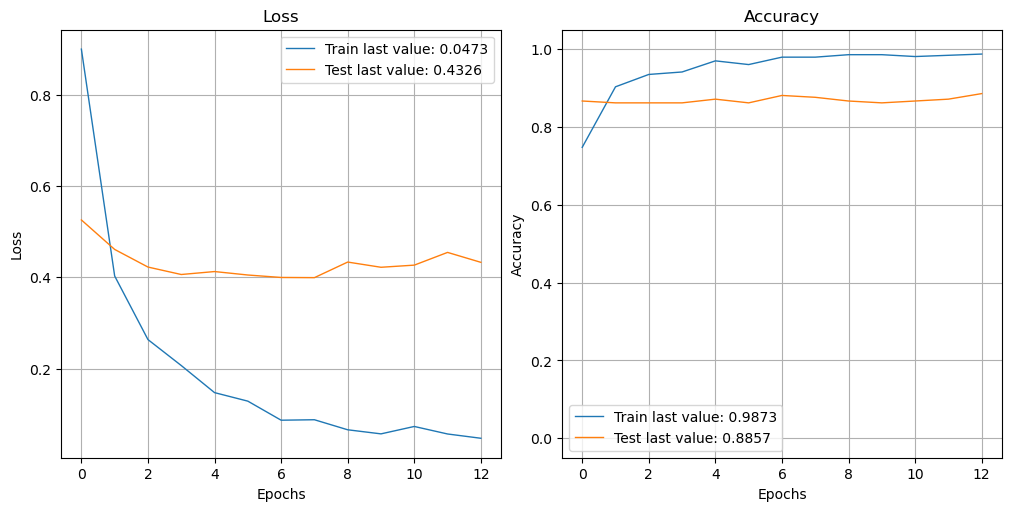

In [32]:
show_history(EfficientNetV2M_1_history)
plot_history(EfficientNetV2M_1_history, path="standard.png")
plt.close()

## with data augmentation

In [33]:
# Create model
EfficientNetV2M_2 = create_model(base_model=EfficientNetV2M)

# Create callback
EfficientNetV2M_2_save_path = "EfficientNetV2M_2_best_weights.h5"
checkpoint = ModelCheckpoint(
    EfficientNetV2M_2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                            

                                                                 ']                               
                                                                                                  
 block2b_project_bn (BatchNorma  (None, 56, 56, 48)  192         ['block2b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_drop (Dropout)         (None, 56, 56, 48)   0           ['block2b_project_bn[0][0]']     
                                                                                                  
 block2b_add (Add)              (None, 56, 56, 48)   0           ['block2b_drop[0][0]',           
                                                                  'block2a_project_bn[0][0]']     
                                                                                                  
 block2c_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 320)  1280       ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 320)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 28, 28, 80)   25600       ['block3b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 80)  320         ['block3b_project_conv[0][0]']   
 lization)

 2D)                                                             ']                               
                                                                                                  
 block4a_bn (BatchNormalization  (None, 14, 14, 320)  1280       ['block4a_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4a_activation (Activation  (None, 14, 14, 320)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 320)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
          

                                                                                                  
 block4c_se_reshape (Reshape)   (None, 1, 1, 640)    0           ['block4c_se_squeeze[0][0]']     
                                                                                                  
 block4c_se_reduce (Conv2D)     (None, 1, 1, 40)     25640       ['block4c_se_reshape[0][0]']     
                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 640)    26240       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 14, 14, 640)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_p

 block4e_se_expand (Conv2D)     (None, 1, 1, 640)    26240       ['block4e_se_reduce[0][0]']      
                                                                                                  
 block4e_se_excite (Multiply)   (None, 14, 14, 640)  0           ['block4e_activation[0][0]',     
                                                                  'block4e_se_expand[0][0]']      
                                                                                                  
 block4e_project_conv (Conv2D)  (None, 14, 14, 160)  102400      ['block4e_se_excite[0][0]']      
                                                                                                  
 block4e_project_bn (BatchNorma  (None, 14, 14, 160)  640        ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_d

 block4g_project_conv (Conv2D)  (None, 14, 14, 160)  102400      ['block4g_se_excite[0][0]']      
                                                                                                  
 block4g_project_bn (BatchNorma  (None, 14, 14, 160)  640        ['block4g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4g_drop (Dropout)         (None, 14, 14, 160)  0           ['block4g_project_bn[0][0]']     
                                                                                                  
 block4g_add (Add)              (None, 14, 14, 160)  0           ['block4g_drop[0][0]',           
                                                                  'block4f_add[0][0]']            
                                                                                                  
 block5a_e

                                                                                                  
 block5c_expand_conv (Conv2D)   (None, 14, 14, 1056  185856      ['block5b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 14, 14, 1056  4224       ['block5c_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5c_expand_activation (Act  (None, 14, 14, 1056  0          ['block5c_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5c_d

                                                                                                  
 block5e_expand_bn (BatchNormal  (None, 14, 14, 1056  4224       ['block5e_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5e_expand_activation (Act  (None, 14, 14, 1056  0          ['block5e_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5e_dwconv2 (DepthwiseConv  (None, 14, 14, 1056  9504       ['block5e_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5e_b

                                                                                                  
 block5g_expand_activation (Act  (None, 14, 14, 1056  0          ['block5g_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5g_dwconv2 (DepthwiseConv  (None, 14, 14, 1056  9504       ['block5g_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5g_bn (BatchNormalization  (None, 14, 14, 1056  4224       ['block5g_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5g_a

                                                                                                  
 block5i_dwconv2 (DepthwiseConv  (None, 14, 14, 1056  9504       ['block5i_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5i_bn (BatchNormalization  (None, 14, 14, 1056  4224       ['block5i_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5i_activation (Activation  (None, 14, 14, 1056  0          ['block5i_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5i_s

                                                                                                  
 block5k_bn (BatchNormalization  (None, 14, 14, 1056  4224       ['block5k_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5k_activation (Activation  (None, 14, 14, 1056  0          ['block5k_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5k_se_squeeze (GlobalAver  (None, 1056)        0           ['block5k_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5k_s

                                                                                                  
 block5m_activation (Activation  (None, 14, 14, 1056  0          ['block5m_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5m_se_squeeze (GlobalAver  (None, 1056)        0           ['block5m_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5m_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block5m_se_squeeze[0][0]']     
                                                                                                  
 block5m_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block5m_se_reshape[0][0]']     
          

                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 1056)        0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 1056)   47520       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_s

 block6c_se_excite (Multiply)   (None, 7, 7, 1824)   0           ['block6c_activation[0][0]',     
                                                                  'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, 7, 7, 304)    554496      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 7, 7, 304)   1216        ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 7, 7, 304)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_a

 block6e_project_bn (BatchNorma  (None, 7, 7, 304)   1216        ['block6e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6e_drop (Dropout)         (None, 7, 7, 304)    0           ['block6e_project_bn[0][0]']     
                                                                                                  
 block6e_add (Add)              (None, 7, 7, 304)    0           ['block6e_drop[0][0]',           
                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 7, 7, 1824)   554496      ['block6e_add[0][0]']            
                                                                                                  
 block6f_e

 block6g_add (Add)              (None, 7, 7, 304)    0           ['block6g_drop[0][0]',           
                                                                  'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 7, 7, 1824)   554496      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 7, 7, 1824)  7296        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 7, 7, 1824)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block6j_expand_bn (BatchNormal  (None, 7, 7, 1824)  7296        ['block6j_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6j_expand_activation (Act  (None, 7, 7, 1824)  0           ['block6j_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6j_dwconv2 (DepthwiseConv  (None, 7, 7, 1824)  16416       ['block6j_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6j_bn (BatchNormalization  (None, 7, 7, 1824)  7296        ['block6j_dwconv2[0][0]']        
 )        

                                                                                                  
 block6l_dwconv2 (DepthwiseConv  (None, 7, 7, 1824)  16416       ['block6l_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6l_bn (BatchNormalization  (None, 7, 7, 1824)  7296        ['block6l_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6l_activation (Activation  (None, 7, 7, 1824)  0           ['block6l_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6l_s

 )                                                                                                
                                                                                                  
 block6n_activation (Activation  (None, 7, 7, 1824)  0           ['block6n_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6n_se_squeeze (GlobalAver  (None, 1824)        0           ['block6n_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6n_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6n_se_squeeze[0][0]']     
                                                                                                  
 block6n_s

 block6p_se_squeeze (GlobalAver  (None, 1824)        0           ['block6p_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6p_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6p_se_squeeze[0][0]']     
                                                                                                  
 block6p_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6p_se_reshape[0][0]']     
                                                                                                  
 block6p_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6p_se_reduce[0][0]']      
                                                                                                  
 block6p_se_excite (Multiply)   (None, 7, 7, 1824)   0           ['block6p_activation[0][0]',     
          

 block6r_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6r_se_reshape[0][0]']     
                                                                                                  
 block6r_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6r_se_reduce[0][0]']      
                                                                                                  
 block6r_se_excite (Multiply)   (None, 7, 7, 1824)   0           ['block6r_activation[0][0]',     
                                                                  'block6r_se_expand[0][0]']      
                                                                                                  
 block6r_project_conv (Conv2D)  (None, 7, 7, 304)    554496      ['block6r_se_excite[0][0]']      
                                                                                                  
 block6r_project_bn (BatchNorma  (None, 7, 7, 304)   1216        ['block6r_project_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 block7b_drop (Dropout)         (None, 7, 7, 512)    0           ['block7b_project_bn[0][0]']     
                                                                                                  
 block7b_add (Add)              (None, 7, 7, 512)    0           ['block7b_drop[0][0]',           
                                                                  'block7a_project_bn[0][0]']     
                                                                                                  
 block7c_expand_conv (Conv2D)   (None, 7, 7, 3072)   1572864     ['block7b_add[0][0]']            
                                                                                                  
 block7c_expand_bn (BatchNormal  (None, 7, 7, 3072)  12288       ['block7c_expand_conv[0][0]']    
 ization) 

                                                                  'block7c_add[0][0]']            
                                                                                                  
 block7e_expand_conv (Conv2D)   (None, 7, 7, 3072)   1572864     ['block7d_add[0][0]']            
                                                                                                  
 block7e_expand_bn (BatchNormal  (None, 7, 7, 3072)  12288       ['block7e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7e_expand_activation (Act  (None, 7, 7, 3072)  0           ['block7e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7e_d

In [34]:
EfficientNetV2M_2_history = fit_model_and_get_history(EfficientNetV2M_2)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 0.8806 - accuracy: 0.7492
Epoch 1: val_loss improved from inf to 0.51978, saving model to EfficientNetV2M_2_best_weights.h5
20/20 [==============================] - 44s 2s/step - loss: 0.8806 - accuracy: 0.7492 - val_loss: 0.5198 - val_accuracy: 0.8524
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.3960 - accuracy: 0.9000
Epoch 2: val_loss improved from 0.51978 to 0.41841, saving model to EfficientNetV2M_2_best_weights.h5
20/20 [==============================] - 34s 2s/step - loss: 0.3960 - accuracy: 0.9000 - val_loss: 0.4184 - val_accuracy: 0.8714
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.9206
Epoch 3: val_loss improved from 0.41841 to 0.39373, saving model to EfficientNetV2M_2_best_weights.h5
20/20 [==============================] - 34s 2s/step - loss: 0.2844 - accuracy: 0.9206 - val_loss: 0.3937 - val_accuracy: 0.8810
Epoch 4/50
20/20 [===========

In [35]:
get_last_epoch_scores(model=EfficientNetV2M_2)

20/20 [==============================] - 25s 1s/step - loss: 0.0251 - accuracy: 0.9905
Training Accuracy   : 0.9905

7/7 [==============================] - 9s 1s/step - loss: 0.4101 - accuracy: 0.8810
Validation Accuracy :  0.8810


In [36]:
get_optimal_epoch_scores(model=EfficientNetV2M_2, model_backup_path=EfficientNetV2M_2_save_path)

Validation Accuracy :  0.8762
Test Accuracy       :  0.8714


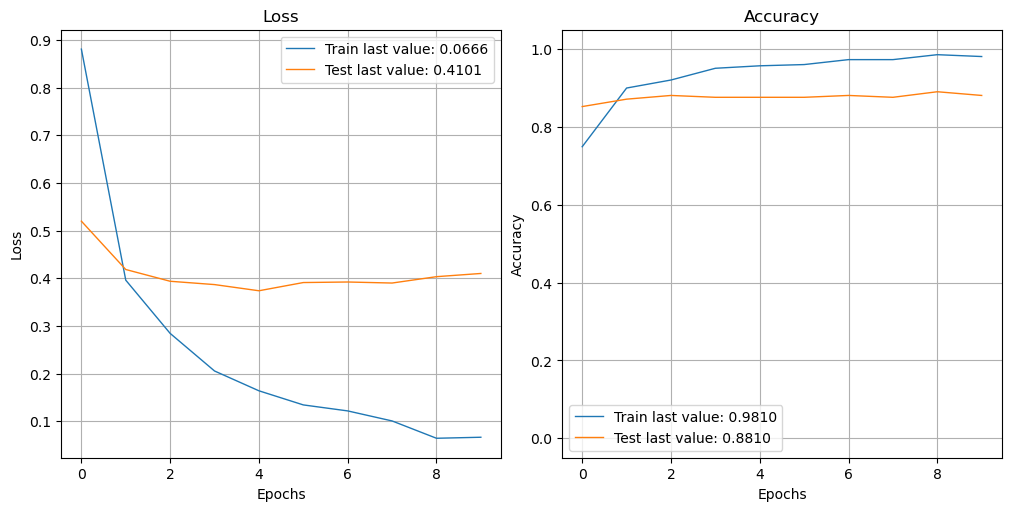

In [37]:
show_history(EfficientNetV2M_2_history)
plot_history(EfficientNetV2M_2_history, path="standard.png")
plt.close()

# ConvNeXtXLarge

## without data augmentation

In [15]:
# Create model
ConvNeXtXLarge_1 = create_model(base_model=ConvNeXtXLarge)

# Create callback
ConvNeXtXLarge_1_save_path = "ConvNeXtXLarge_1_best_weights.h5"
checkpoint = ModelCheckpoint(
    ConvNeXtXLarge_1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 convnext_xlarge_prestem_no  (None, 224, 224, 3)          0         ['input_2[0][0]']             
 rmalization (Normalization                                                                       
 )                                                                                                
                                                                                                  
 convnext_xlarge_stem (Sequ  (None, 56, 56, 256)          13056     ['convnext_xlarge_prestem_norm
 ential)                                                            alization[0][0]']       

In [16]:
ConvNeXtXLarge_1_history = fit_model_and_get_history(ConvNeXtXLarge_1)

Epoch 1/50


2023-08-14 11:01:02.795483: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3c2234980 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-08-14 11:01:02.795512: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-08-14 11:01:02.810331: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 [==============================] - ETA: 0s - loss: 0.6667 - accuracy: 0.7937 
Epoch 1: val_loss improved from inf to 0.28890, saving model to ConvNeXtXLarge_1_best_weights.h5


/Users/bibi/miniforge3/envs/convnext/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 549s 28s/step - loss: 0.6667 - accuracy: 0.7937 - val_loss: 0.2889 - val_accuracy: 0.9190
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.9603 
Epoch 2: val_loss improved from 0.28890 to 0.25581, saving model to ConvNeXtXLarge_1_best_weights.h5
20/20 [==============================] - 545s 28s/step - loss: 0.1439 - accuracy: 0.9603 - val_loss: 0.2558 - val_accuracy: 0.9190
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9762 
Epoch 3: val_loss did not improve from 0.25581
20/20 [==============================] - 548s 28s/step - loss: 0.0831 - accuracy: 0.9762 - val_loss: 0.3446 - val_accuracy: 0.9000
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9873 
Epoch 4: val_loss did not improve from 0.25581
20/20 [==============================] - 542s 27s/step - loss: 0.0476 - accuracy: 0.9873 - val_loss: 0.2823 - val_accuracy: 0.9

In [17]:
get_last_epoch_scores(model=ConvNeXtXLarge_1)

20/20 [==============================] - 412s 21s/step - loss: 0.0062 - accuracy: 0.9968
Training Accuracy   : 0.9968

7/7 [==============================] - 139s 20s/step - loss: 0.3066 - accuracy: 0.9238
Validation Accuracy :  0.9238


In [18]:
get_optimal_epoch_scores(model=ConvNeXtXLarge_1, model_backup_path=ConvNeXtXLarge_1_save_path)

Validation Accuracy :  0.9190
Test Accuracy       :  0.9143


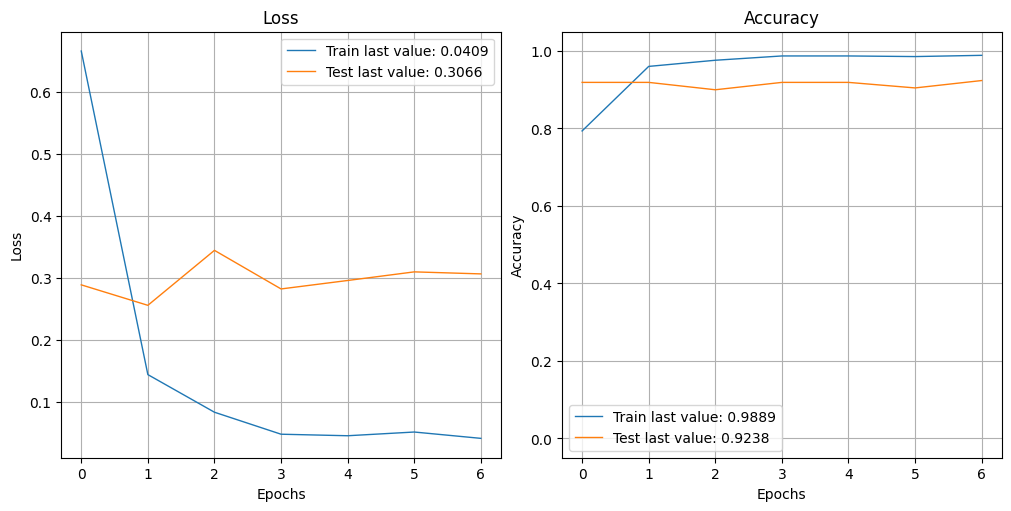

In [19]:
show_history(ConvNeXtXLarge_1_history)
plot_history(ConvNeXtXLarge_1_history, path="standard.png")
plt.close()

## with data augmentation

In [20]:
# Create model
ConvNeXtXLarge_2 = create_model(base_model=ConvNeXtXLarge)

# Create callback
ConvNeXtXLarge_2_save_path = "ConvNeXtXLarge_2_best_weights.h5"
checkpoint = ModelCheckpoint(
    ConvNeXtXLarge_2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 convnext_xlarge_prestem_no  (None, 224, 224, 3)          0         ['input_3[0][0]']             
 rmalization (Normalization                                                                       
 )                                                                                                
                                                                                                  
 convnext_xlarge_stem (Sequ  (None, 56, 56, 256)          13056     ['convnext_xlarge_prestem_norm
 ential)                                                            alization[0][0]']       

In [21]:
ConvNeXtXLarge_2_history = fit_model_and_get_history(ConvNeXtXLarge_2)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 0.6215 - accuracy: 0.8000 
Epoch 1: val_loss improved from inf to 0.33547, saving model to ConvNeXtXLarge_2_best_weights.h5
20/20 [==============================] - 969s 50s/step - loss: 0.6215 - accuracy: 0.8000 - val_loss: 0.3355 - val_accuracy: 0.8762
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.1763 - accuracy: 0.9540 
Epoch 2: val_loss improved from 0.33547 to 0.26932, saving model to ConvNeXtXLarge_2_best_weights.h5
20/20 [==============================] - 546s 28s/step - loss: 0.1763 - accuracy: 0.9540 - val_loss: 0.2693 - val_accuracy: 0.9048
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9810  
Epoch 3: val_loss improved from 0.26932 to 0.23238, saving model to ConvNeXtXLarge_2_best_weights.h5
20/20 [==============================] - 1582s 82s/step - loss: 0.0919 - accuracy: 0.9810 - val_loss: 0.2324 - val_accuracy: 0.9286
Epoch 4/50
20/20 [===

In [22]:
get_last_epoch_scores(model=ConvNeXtXLarge_2)

20/20 [==============================] - 407s 20s/step - loss: 0.0238 - accuracy: 0.9905
Training Accuracy   : 0.9905

7/7 [==============================] - 138s 20s/step - loss: 0.3348 - accuracy: 0.8952
Validation Accuracy :  0.8952


In [23]:
get_optimal_epoch_scores(model=ConvNeXtXLarge_2, model_backup_path=ConvNeXtXLarge_2_save_path)

Validation Accuracy :  0.9286
Test Accuracy       :  0.9190


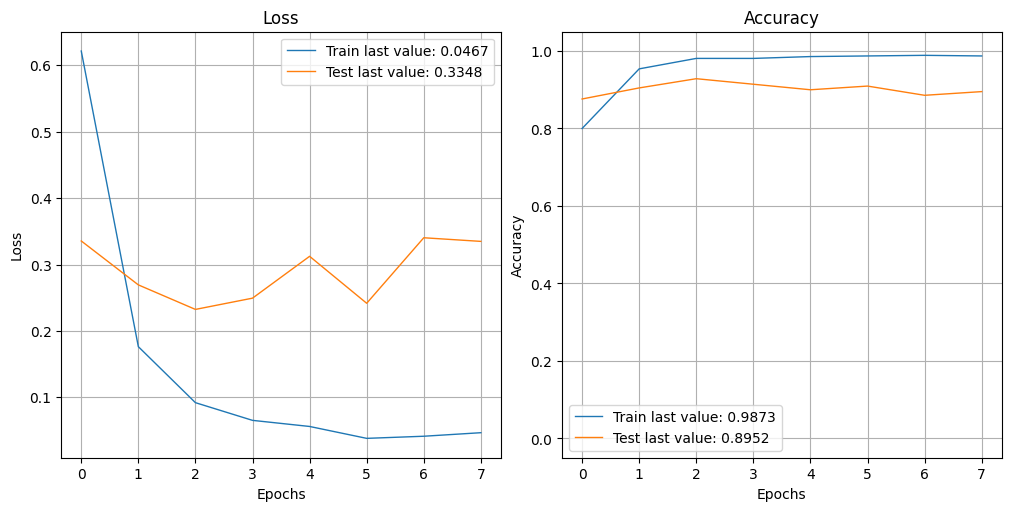

In [24]:
show_history(ConvNeXtXLarge_2_history)
plot_history(ConvNeXtXLarge_2_history, path="standard.png")
plt.close()